# Using Vertex AI Vizier for ML model hyperparameter tuning


## Introduction

This example demonstrates the use of [Vertex AI Vizier](https://cloud.google.com/vertex-ai/docs/vizier/overview) for [hyperparameter (HP) tuning](https://en.wikipedia.org/wiki/Hyperparameter_optimization) of an ML model. Vertex AI Vizier is a black-box optimization service. You will often see Vertex AI Vizier used to optimize hyperparameters of ML models, but it can also perform other optimization tasks.

<img src="https://storage.googleapis.com/amy-jo/images/vertex/vizier/vizier1.png" width="65%">

**For more information about the model and dataset used in this example, see [the `01_keras_pcam` notebook](app.terra.bio/#workspaces/verily-terra-solutions/ml-on-terra/notebooks/launch/01_keras_pcam.ipynb)**. As with that notebook, we'll train a model using the workspace's Cloud Environment, but this time we'll use Vizier for HP tuning.

For this notebook, use the default Terra Cloud Environment image, **customized to use at least 1 GPU and at least 4 cores**.

> **Note**: The [02_2_vertex_ai_pcam.ipynb](https://app.terra.bio/#workspaces/verily-terra-solutions/ml-on-terra/notebooks/launch/02_2_vertex_ai_pcam.ipynb) notebook also includes an HP tuning example. That example uses a service that is integrated with Vertex AI training. The Vizier service— that we show here— is a standalone optimization service, so it can be used for any optimization task that you like, and is thus more flexible.
Under the hood, both use the same underlying technology.


### 'Native' GCP project required

This example requires a ['native' GCP project](https://support.terra.bio/hc/en-us/articles/360051229072-Accessing-advanced-GCP-features-in-Terra).  The Vizier service will be run using that project, not your Terra workspace project.

### Hyperparameters and optimization objective

In this simple example, we'll use batch size and learning rate as the hyperparameters, and optimize for accuracy.

### Overview of running a Vizier *study*

Here is an overview of the process for setting up and running a Vizier study. The specifics are in the code below.

- Create a *study* configuration. This includes info on the parameter(s) that you want to tune,your objective metric(s), and the HP search algorithm to use.
- Create a Vizier client object via the `aiplatform` libs, which you'll use to interact with the service.
- Create a Vizier *study* via the client object
- Define function(s) to evaluate the objective metric(s).
- Run the trials by interacting with the Vizier client to get "suggested" trial param sets. Run your evaluation functions using the suggested trial param sets.
- Record the outcome of a given trial with the Vizier client. You use a `client_id` to indicate the identifier of the client that is requesting the suggestion. If multiple suggestion requests have the same `client_id`, the service will return the identical suggested trial if the trial is PENDING, and provide a new trial if the last suggested trial was completed.
- Request information from Vizier about the optimal trials. It returns the pareto-optimal trials for a multi-objective study, or the optimal trials for a single-objective study.

### Costs

This tutorial uses Vertex AI Vizier. Pricing information is [here](https://cloud.google.com/vertex-ai/pricing#vizier).
For this simple example, which uses `RANDOM_SEARCH`, there should not be a charge to your 'native' GCP project, so you should just incur the costs of running this notebook. 


## Setup

### Install the Vertex AI library

Download and install the Vertex AI library. You only need to run this once for a given persistent disk. (On the default Terra image, this library should already be installed, though this command will update it if need be).

In [ ]:
! unset PIP_TARGET ; pip install --user --upgrade google-cloud-aiplatform

In [ ]:
# Restart the kernel after pip installs
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

### Set up your 'native' Google Cloud project

1. If you have not already done so, follow the instructions [here](https://support.terra.bio/hc/en-us/articles/360051229072-Accessing-advanced-GCP-features-in-Terra) for a GCP project, including creating a Terra group as necessary, and then adding your Terra group on the Google project. You'll need to enable billing as described in the article.

2. Then, [enable the Vertex AI APIs](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com) for your project.

You'll need to fill in the project ID for your native project in the next cell.


### Import libraries and define constants

**Before you run the following cell**, set the `PROJECT_ID` for your ['native' GCP project](https://support.terra.bio/hc/en-us/articles/360051229072-Accessing-advanced-GCP-features-in-Terra).

In [1]:
REGION = "us-central1"
# Set your 'native' GCP project ID here, NOT your workspace project ID
PROJECT_ID = "YOUR-NATIVE-PROJECT-ID"  # CHANGE THIS

In [2]:
import json
import os
from datetime import datetime

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

from google.cloud import aiplatform

2.7.0


In [3]:
if (
    "GOOGLE_PROJECT" in os.environ
):  # This env var is set when running in a Terra workspace

    WORKSPACE_NAME = os.environ["WORKSPACE_NAME"]
    WORKSPACE_NAMESPACE = os.environ["WORKSPACE_NAMESPACE"]
    WORKSPACE_BUCKET = os.environ["WORKSPACE_BUCKET"]
else:
    print("Not running on Terra: you will need to set your GCP bucket manually.")

In [ ]:
BUCKET = WORKSPACE_BUCKET
print(BUCKET)

## Create the tissue datasets

This process will take a while. We'll download to the persistent disk, so that you only need to do the download once (per PD).  So, if you have already run the [01_keras_pcam](app.terra.bio/#workspaces/verily-terra-solutions/ml-on-terra/notebooks/launch/01_keras_pcam.ipynb) on the same PD, the `load` method should run very quickly.

In [12]:
# load the input data from tensorflow_datasets
ds, ds_info = tfds.load(
    "patch_camelyon",
    with_info=True,
    as_supervised=True,
    data_dir="/home/jupyter/tensorflow_datasets",
)

# get the train, validation and test datasets
train_data = ds["train"]
valid_data = ds["validation"]
test_data = ds["test"]

In [13]:
print(ds_info)

tfds.core.DatasetInfo(
    name='patch_camelyon',
    full_name='patch_camelyon/2.0.0',
    description="""
    The PatchCamelyon benchmark is a new and challenging image classification
    dataset. It consists of 327.680 color images (96 x 96px) extracted from
    histopathologic scans of lymph node sections. Each image is annoted with a
    binary label indicating presence of metastatic tissue. PCam provides a new
    benchmark for machine learning models: bigger than CIFAR10, smaller than
    Imagenet, trainable on a single GPU.
    """,
    homepage='https://patchcamelyon.grand-challenge.org/',
    data_path='/home/jupyter/tensorflow_datasets/patch_camelyon/2.0.0',
    download_size=7.48 GiB,
    dataset_size=7.06 GiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shu

In [16]:
# shuffle the train_data
buffer_size = 1000
train_data = train_data.shuffle(buffer_size)

We can view a few of the images:

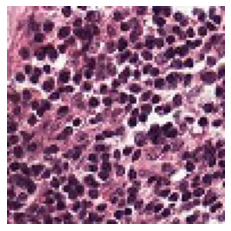

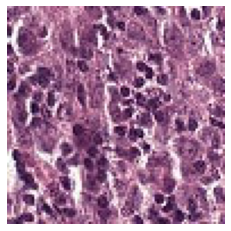

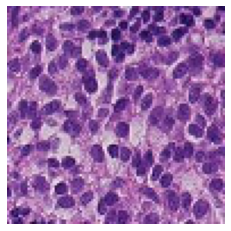

In [17]:
batch_size = 32
train_datat = train_data.batch(batch_size).prefetch(1)

for images, labels in train_datat.take(3):
    plt.figure(figsize=(4, 4))
    first_image = images[0]
    plt.imshow(first_image.numpy().astype("int32"))
    plt.axis("off")

## Define a Keras image classification model

In this section, we'll define the Keras model that we'll use for training. We'll use [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) for this example, starting with a model— the [Xception](https://keras.io/api/applications/xception/) convolutional neural network architecture — that has been trained on [ImageNet](https://www.image-net.org/) data, and adding some additional layers to that model. We'll 'freeze' the Xception base model, so that its weights don't change during training; only the weights of our new layers will change.

In [27]:
def get_compiled_model(learning_rate):
    base_model = keras.applications.Xception(
        weights="imagenet", input_shape=(96, 96, 3), include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(96, 96, 3))

    x = layers.Rescaling(1.0 / 255)(inputs)
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(2, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=loss,
        metrics=["accuracy"],
    )
    return (base_model, model)

In [28]:
def run_model_training(
    batch_size, learning_rate, tdata, vdata, tstdata, log_dir, epochs
):

    # batch and prefetch
    train_data = tdata.batch(batch_size).prefetch(1)
    valid_data = vdata.batch(batch_size).prefetch(1)
    test_data = tstdata.batch(batch_size).prefetch(1)

    ts = datetime.now().strftime("%Y%m%d%H%M%S")
    print(ts)

    model = get_compiled_model(learning_rate)
    strategy = tf.distribute.MirroredStrategy()
    print("Number of devices: {}".format(strategy.num_replicas_in_sync))
    if strategy.num_replicas_in_sync > 1:
        print("Using mirrored strategy.")
        with strategy.scope():
            base_model, model = get_compiled_model(learning_rate)
    else:
        base_model, model = get_compiled_model(learning_rate)
    model.summary()

    # Define some training 'callbacks'. One logs in a format used by https://www.tensorflow.org/tensorboard.
    # The other sets up model checkpointing.
    # If training is interrupted for some reason, we can reconstitute the last-saved model from the
    # checkpoint directory.
    print(log_dir)
    checkpoint_dir = f"./checkpoints/{ts}/checkpoints"
    print(checkpoint_dir)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir, update_freq=300
    )

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir, monitor="val_accuracy", mode="max", save_freq="epoch"
    )

    model.fit(
        train_data,
        epochs=epochs,
        callbacks=[tensorboard_callback, model_checkpoint_callback],
        validation_data=valid_data,
    )

    # get some metrics info
    print(f"model history: {model.history.history}")
    val_accuracy = (model.history.history["val_accuracy"])[-1]
    val_loss = (model.history.history["val_loss"])[-1]
    print(f"val_loss: {val_loss}; val_accuracy: {val_accuracy}")
    #   eval_res = model.evaluate(test_data)
    #   print(f"eval res: {eval_res}")
    return (model, val_accuracy)

## Define and run a Vizier *study*


Set some variables.  Ensure that your `PROJECT_ID` is set correctly.

In [ ]:
STUDY_DISPLAY_NAME = "{}_study_{}".format(
    PROJECT_ID.replace("-", ""), datetime.now().strftime("%Y%m%d_%H%M%S")
)  # @param {type: 'string'}
ENDPOINT = REGION + "-aiplatform.googleapis.com"
PARENT = "projects/{}/locations/{}".format(PROJECT_ID, REGION)

print("ENDPOINT: {}".format(ENDPOINT))
print("REGION: {}".format(REGION))
print("PARENT: {}".format(PARENT))

### Create the *study* configuration

The study configuration is built as a hierarchical python dictionary. It is already filled out. Run the cell to configure the study.

In [ ]:
# Parameter Configuration

param_batch_size = {
    "parameter_id": "batch_size",
    "discrete_value_spec": {"values": [16, 32, 64, 128, 256], "default_value": 32},
}

param_learning_rate = {
    "parameter_id": "learning_rate",
    "discrete_value_spec": {"values": [1e-4, 1e-3, 1e-2, 1e-1], "default_value": 1e-3},
}

# Objective Metrics
metric_acc = {"metric_id": "accuracy", "goal": "MAXIMIZE"}


# Put it all together in a study configuration
study = {
    "display_name": STUDY_DISPLAY_NAME,
    "study_spec": {
        "algorithm": "RANDOM_SEARCH",
        "parameters": [
            param_batch_size,
            param_learning_rate,
        ],
        "metrics": [metric_acc],
    },
}

print(json.dumps(study, indent=2, sort_keys=True))

### Create the Vizier *study*

Next, create the study, which you will run to optimize the objective.

In [ ]:
vizier_client = aiplatform.gapic.VizierServiceClient(
    client_options=dict(api_endpoint=ENDPOINT)
)
study = vizier_client.create_study(parent=PARENT, study=study)
STUDY_ID = study.name
print("STUDY_ID: {}".format(STUDY_ID))

### Metric evaluation functions

Next, define a function to evaluate the objective metric.

In [60]:
def CreateMetrics(trial_id, batch_size, learning_rate, epochs, study_disp_name):
    print(("=========== Start Trial: [{}] =============").format(trial_id))
    print(f"using batch_size {batch_size}; learning_rate {learning_rate}")

    # Evaluate objective metrics for this trial
    LOG_DIR = f"{BUCKET}/logs/pcam/{study_disp_name}/{trial_id.split('/')[-1]}"
    print(LOG_DIR)

    m, accuracy = run_model_training(
        batch_size, learning_rate, train_data, valid_data, test_data, LOG_DIR, epochs
    )
    print(f"accuracy: {accuracy}")

    acc = {"metric_id": "accuracy", "value": accuracy}

    # Return the results for this trial
    return [acc]

### Set configuration parameters for running trials

__`client_id`__: The identifier of the client that is requesting the suggestion. If multiple suggestion requests have the same `client_id`, the service will return the identical suggested trial if the trial is `PENDING`, and provide a new trial if the last suggested trial was completed.

__`suggestion_count_per_request`__: The number of suggestions (trials) requested in a single request.

__`max_trial_id_to_stop`__: The number of trials to explore before stopping. It is set to 15 to shorten the time to run the code, so don't expect convergence. For convergence, it would likely need to be about 20 (a good rule of thumb is to multiply the total dimensionality by 10).


In [ ]:
client_id = "client_pcam"
suggestion_count_per_request = 1
# For example purposes, we'll only run two trials.  In a 'real' study you'd want more.
# Feel free to edit this variable if you like.
max_trial_id_to_stop = 2

print("client_id: {}".format(client_id))
print("suggestion_count_per_request: {}".format(suggestion_count_per_request))
print("max_trial_id_to_stop: {}".format(max_trial_id_to_stop))

### Run Vertex Vizier trials

Run the trials.

In [ ]:
trial_id = 0
EPOCHS = 2

while int(trial_id) < max_trial_id_to_stop:
    suggest_response = vizier_client.suggest_trials(
        {
            "parent": STUDY_ID,
            "suggestion_count": suggestion_count_per_request,
            "client_id": client_id,
        }
    )

    for suggested_trial in suggest_response.result().trials:
        trial_id = suggested_trial.name.split("/")[-1]
        trial = vizier_client.get_trial({"name": suggested_trial.name})

        if trial.state in ["COMPLETED", "INFEASIBLE"]:
            continue

        for param in trial.parameters:
            if param.parameter_id == "batch_size":
                batch_size = param.value
            elif param.parameter_id == "learning_rate":
                learning_rate = param.value
        print(
            "Trial : batch_size is {}, learning_rate is {}.".format(
                batch_size, learning_rate
            )
        )

        vizier_client.add_trial_measurement(
            {
                "trial_name": suggested_trial.name,
                "measurement": {
                    "metrics": CreateMetrics(
                        suggested_trial.name,
                        int(batch_size),
                        learning_rate,
                        EPOCHS,
                        STUDY_DISPLAY_NAME,
                    )
                },
            }
        )

        response = vizier_client.complete_trial(
            {"name": suggested_trial.name, "trial_infeasible": False}
        )

### List the optimal solutions

`list_optimal_trials` returns the [pareto-optimal](https://en.wikipedia.org/wiki/Pareto_efficiency) trials for a multi-objective study, or the optimal trials for single-objective study. For this example, we defined a single-objective study.

In [ ]:
optimal_trials = vizier_client.list_optimal_trials({"parent": STUDY_ID})

print("optimal_trials: {}".format(optimal_trials))

### View your trial results in the Vertex AI UI

To view and compare your trial results, you can visit the [Vertex AI "Experiments" panel](https://console.cloud.google.com/vertex-ai/experiments/experiments) in the GCP Cloud Console, then click on the **VIZIER STUDIES** tab. From there, click in to a "Study name".

You can view info about the trial metrics as they are run.  For example, here is an study using the example from this notebook, after 6 trials:
<img src="https://storage.googleapis.com/amy-jo/images/vertex/vizier/vizier2.png">

...and after 15 trials, sorted by the target metric, `accuracy`:
<img src="https://storage.googleapis.com/amy-jo/images/vertex/vizier/vizier1.png">

## Listing, fetching, and deleting studies



In [ ]:
# To list studies in a specific project and region, send the following request:
vizier_client.list_studies({"parent": PARENT})

In [ ]:
# To get a study config, send the following request
# The STUDY_ID string has the format 'projects/<your_project_number>/locations/us-central1/studies/<study_id>'
vizier_client.get_study({"name": STUDY_ID})

In [ ]:
# To delete a study:
vizier_client.delete_study({"name": STUDY_ID})

---
Copyright 2022 Verily Life Sciences LLC

Use of this source code is governed by a BSD-style    
license that can be found in the LICENSE file or at    
https://developers.google.com/open-source/licenses/bsd